Using TensorFlow backend.


(-1.1057178010821211,
 1.1094151787007132,
 -1.1120352255976402,
 1.10057310598084)

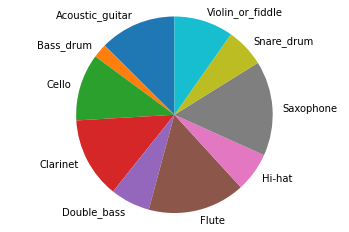

In [2]:
import os
from scipy.io import wavfile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


from keras.layers import Conv2D, MaxPool2D, Flatten, LSTM
from keras.layers import Dropout, Dense, TimeDistributed
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from config import Config
from tqdm import tqdm
from python_speech_features import mfcc

import pickle
from keras.callbacks import ModelCheckpoint


df = pd.read_csv('../data/meta/small_train_labels.csv')
df.set_index('fname', inplace=True)

for f in df.index:
    rate, signal = wavfile.read('../data/clean/' + f)
    df.at[f, 'length'] = signal.shape[0] / rate
    
classes = list(np.unique(df.label))
class_dist = df.groupby(['label'])['length'].mean()

n_samples = 2 * int(df['length'].sum() / 0.1)
prob_dist = class_dist / class_dist.sum()
choices = np.random.choice(class_dist.index, p=prob_dist)

fig, ax = plt.subplots()
ax.pie(class_dist, labels=class_dist.index, shadow=False, startangle=90)
ax.axis('equal')

In [3]:
def get_conv_model():
    model = Sequential()
    model.add(Conv2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same', input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu', strides=(1, 1), padding='same', input_shape=input_shape))
    model.add(Conv2D(128, (3, 3), activation='relu', strides=(1, 1), padding='same', input_shape=input_shape))
    
    model.add(MaxPool2D((2, 2)))
    model.add(Dropout(0,5))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    return model

def get_recurrent_model():
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(64, activation='relu')))
    model.add(TimeDistributed(Dense(32, activation='relu')))
    model.add(TimeDistributed(Dense(16, activation='relu')))
    model.add(TimeDistributed(Dense(8, activation='relu')))
    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    return model

In [4]:
def check_data():
    if os.path.isfile(config.p_path):
        print('Loading existing data for {} model'.format(config.model))
        with open(config.p_path, 'rb') as handle:
            tmp = pickle.load(handle)
            return tmp
    else:
        return None

In [5]:
def build_rand_feat():
    tmp = check_data()
    if tmp:
        return tmp.data[0], tmp.data[1]
    X = []
    y = []
    _min, _max = float('inf'), -float('inf')
    for _ in tqdm(range(n_samples)):
        rand_class = np.random.choice(class_dist.index, p = prob_dist)
        file = np.random.choice(df[df.label == rand_class].index)
        rate, wav = wavfile.read('../data/clean/' + file)
        label = df.at[file, 'label']
        rand_index = np.random.randint(0, wav.shape[0] - config.step)
        sample = wav[rand_index:rand_index+config.step]
        X_sample = mfcc(sample, rate,
                       numcep=config.nfeat, nfilt=config.nfilt, nfft=config.nfft).T
        _min = min(np.amin(X_sample), _min)
        _max = max(np.amax(X_sample), _max)
        # X.append(X_sample if config.mode == 'conv' else X_sample.T)
        X.append(X_sample)
        y.append(classes.index(label))
    config.min = _min
    config.max = _max
        
    X, y = np.array(X), np.array(y)
    X = (X - _min) / (_max - _min)
        
        
    if config.mode == 'conv':
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
    elif config.mode == 'time':
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2])
            
    y = to_categorical(y, num_classes=10)
    config.data = (X, y)

    with open(config.p_path, 'wb') as handle:
        # protocol 2 to be backcomp with python 2.x
        pickle.dump(config, handle, protocol=2)
    return X, y

In [ ]:
config = Config(mode='time')

if config.mode == 'conv':
    X, y = build_rand_feat()
    y_flat = np.argmax(y, axis=1)
    input_shape = (X.shape[1], X.shape[2], 1)
    model = get_conv_model()
    
elif config.mode == 'time':
    X, y = build_rand_feat()
    y_flat = np.argmax(y, axis=1)
    input_shape = (X.shape[1], X.shape[2])
    model = get_recurrent_model()
    

class_weight = compute_class_weight('balanced', np.unique(y_flat), y_flat)

checkpoint = ModelCheckpoint(config.model_path, monitor='val_acc', verbose=1, mode='max', save_best_only=True, save_weights_only=False, period=1)

model.fit(X, y, epochs=10, batch_size=32, shuffle=True, validation_split=0.1, callbacks=[checkpoint])

model.save(config.model_path)

100%|███████████████████████████████████████████████████████████████████████████| 26410/26410 [00:54<00:00, 484.29it/s]


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 13, 128)           70656     
_________________________________________________________________
lstm_2 (LSTM)                (None, 13, 128)           131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 13, 128)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 13, 64)            8256      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 13, 32)            2080      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 13, 16)            528       
_________________________________________________________________
time_distributed_4 (TimeDist (None, 13, 8)            

C:\Users\selic\miniconda3\envs\onioEnv\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass classes=[0 1 2 3 4 5 6 7 8 9], y=[4 2 5 ... 2 2 7] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Train on 23769 samples, validate on 2641 samples
Epoch 1/10
23769/23769 [==============================] - 18s 771us/step - loss: 1.9432 - acc: 0.2623 - val_loss: 1.5976 - val_acc: 0.4192

Epoch 00001: val_acc improved from -inf to 0.41916, saving model to ../models\time.model
Epoch 2/10
23769/23769 [==============================] - 18s 738us/step - loss: 1.4785 - acc: 0.4590 - val_loss: 1.3489 - val_acc: 0.5354

Epoch 00002: val_acc improved from 0.41916 to 0.53540, saving model to ../models\time.model
Epoch 3/10
23769/23769 [==============================] - 18s 755us/step - loss: 1.2435 - acc: 0.5551 - val_loss: 1.1467 - val_acc: 0.6017

Epoch 00003: val_acc improved from 0.53540 to 0.60167, saving model to ../models\time.model
Epoch 4/10
23769/23769 [==============================] - 15s 646us/step - loss: 1.0772 - acc: 0.6169 - val_loss: 1.0519 - val_acc: 0.6270

Epoch 00004: val_acc improved from 0.60167 to 0.62704, saving model to ../models\time.model
Epoch 5/10
23769/23769 [==